## Final Project Submission

Please fill out:
* Student name:Fidelis Wanalwenge, Elizabeth Nyambura, Sylvia Murithi, Khadija Omar 
* Student pace:Part Time 
* Scheduled project review date/time: 11/09/2023
* Instructor name: Asha, Stellah, Mwikali
* Blog post URL:


# Introduction

The goal of this project is to conduct extensive research on the real estate market in King County in order to explore the potential of renovating specific areas of a property to increase its value and make it more attractive to potential buyers. This approach can help homeowners to add functionality and beauty to their property while simultaneously boosting its resale value

To achieve this objective, we will employ multiple linear regression modeling to analyze house sales data in the King County area. By using statistical techniques, we aim to identify key factors that impact property sales in the region and provide valuable insights to guide our recommendations.

The first sections focus on investigating, cleaning, wrangling, and engineering some new features. The next section contains 2 models and evaluation of each, ultimately leading to us to select our best model for predicting house prices thhat will maximize profit. Finally, we will make recommendations and provide insight on house features that have the biggest impact on sale price to a team of real estate agents that are looking to get into the business of remodeling houses.

# Business Problem

A group of real estate agents are looking to expand their business into renovating houses in addition to selling. They need guidance on assisting clients with recommendations on which home renovations may increase the estimated value of their homes. They want to accurately predict the value of homes based on the features of the house so they can maximize profits for their remodels. In order to accomplish this, they have enlisted our help in building a model to predict the price of homes in the county. 

Objectives:

1. To provide insight on house features that have the biggest impact on sale price

2. To create a complex model using several different independent variables that can swifty and effectively achieve pricing estimates that may increase the estimated value of their homes

3. To evaluate different models that ultimately lead to selecting our best model for maximizing profit after renovation


# The Data

This data originates from the King County House Sales dataset, accessible through the King County Open Data platform. The dataset contains information on single-family home sales spanning from 2014 to 2015.

The aspects I will be examining are as follows:

1. price - sales price

2. bedrooms - Number of bedrooms

3. bathrooms - Number of bathrooms

4. sqft_living - Square footage of living space in the home

5. sqft_lot - Square footage of the lot

6. floors - Number of floors (levels) in house

7. waterfront - whether the house is on a waterfront

8. grade - Overall grade of the house. Related to the construction and design of the house

9. yr_built - Year when house was built

10. condition - How good the overall condition of the house is. Related to maintenance of house

# Rationale

In choosing statistical analyses over basic data visualization, we opt for a more nuanced understanding of the intricate relationships within our dataset. While graphs offer visual representation, regression coefficients provide precise quantification of each feature's impact on house prices. This level of detail is paramount in the complex realm of real estate, where numerous factors converge to determine property values. Through regression analysis, we can discern subtle effects and interactions, offering a comprehensive assessment for our business audience. Our modeling process was guided by these statistical insights, ensuring the model's accuracy and effectiveness.

# Data Preparation

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load the data into a pandas dataframe
df = pd.read_csv("data/kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
#Check the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
#Check the descriptive statistics
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [5]:
#Check for duplicated values
df.duplicated().sum()

0

In [6]:
#Check for missing values
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

# Initial Observations

Missing Values

yr_renovated has the most missing values, followed by waterfront and view. waterfront and view are categorical, so we will replace those null values with 0s. I will assume null values in yr_renovated mean that the house has not been renovated and will replace with 0s.

Data types

The date, waterfront, view, condition, grade, sqft_basement columns are stored as type object, we will need to remove or convert to numerical data type before modeling.

# Data Cleaning

In this section, I will clean the dataset by removing irrelevant columns to my analysis and trim the dataset of null values. I will also remove outliers and convert the remaining categorical columns containing strings into numeric datatypes.

In [7]:
#Create copy to use for visualization later
data =df.copy()


In [8]:
# Columns to be dropped
dropped_columns = ['date','view', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'sqft_basement','yr_renovated', 'lat', 'long', 'zipcode']

In [9]:
#dropping columns
df = df.drop(dropped_columns, axis=1)

In [10]:
#view remaining columns
df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade', 'yr_built'],
      dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           21597 non-null  int64  
 1   price        21597 non-null  float64
 2   bedrooms     21597 non-null  int64  
 3   bathrooms    21597 non-null  float64
 4   sqft_living  21597 non-null  int64  
 5   sqft_lot     21597 non-null  int64  
 6   floors       21597 non-null  float64
 7   waterfront   19221 non-null  object 
 8   condition    21597 non-null  object 
 9   grade        21597 non-null  object 
 10  yr_built     21597 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.8+ MB


In [12]:
#check null values
df.isna().sum()

id                0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront     2376
condition         0
grade             0
yr_built          0
dtype: int64

In [13]:
# Replace null values with 0
df = df.fillna(0)

In [14]:
#check if it has worked
df.isna().sum()

id             0
price          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
floors         0
waterfront     0
condition      0
grade          0
yr_built       0
dtype: int64

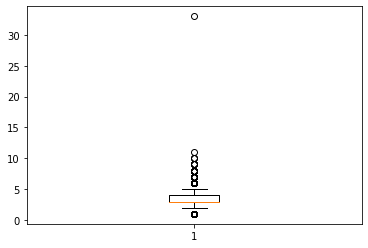

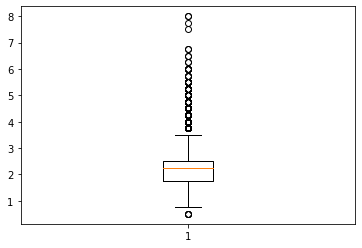

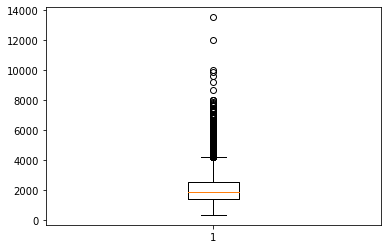

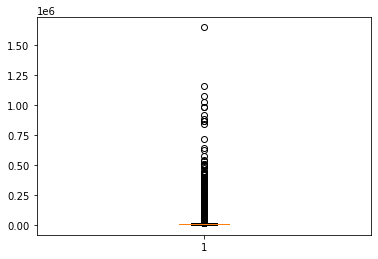

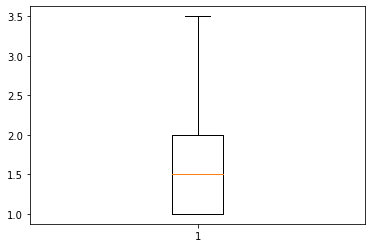

In [15]:
# Check continuous predictors for outliers using Boxplot 

outliers = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors']

for outlier in outliers:
    plt.figure()
    plt.boxplot(df[outlier]);

In [16]:
# Investigate outlier in the bedrooms column
df.loc[df['bedrooms'] > 15]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
15856,2402100895,640000.0,33,1.75,1620,6000,1.0,NO,Very Good,7 Average,1947


In [17]:
# Remove outlier
df = df.loc[(df['bedrooms'] != 33)]
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,Average,7 Average,1955
1,6414100192,538000.0,3,2.25,2570,7242,2.0,NO,Average,7 Average,1951
2,5631500400,180000.0,2,1.00,770,10000,1.0,NO,Average,6 Low Average,1933
3,2487200875,604000.0,4,3.00,1960,5000,1.0,NO,Very Good,7 Average,1965
4,1954400510,510000.0,3,2.00,1680,8080,1.0,NO,Average,8 Good,1987


In [18]:
# Check to see if it worked
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           21596 non-null  int64  
 1   price        21596 non-null  float64
 2   bedrooms     21596 non-null  int64  
 3   bathrooms    21596 non-null  float64
 4   sqft_living  21596 non-null  int64  
 5   sqft_lot     21596 non-null  int64  
 6   floors       21596 non-null  float64
 7   waterfront   21596 non-null  object 
 8   condition    21596 non-null  object 
 9   grade        21596 non-null  object 
 10  yr_built     21596 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 2.0+ MB


In [20]:
# Convert categorical strings to integers
# Convert categorical strings to integers
df['waterfront'] = df['waterfront'].replace(('YES', 'NO'), (1, 0))

condition_mapping = {
    'Poor': 0,
    'Fair': 1,
    'Average': 2,
    'Good': 3,
    'Very Good': 4
}
df['condition'] = df['condition'].map(condition_mapping)

grade_mapping = {
    '3 Poor': 3,
    '4 Low': 4,
    '5 Fair': 5,
    '6 Low Average': 6,
    '7 Average': 7,
    '8 Good': 8,
    '9 Better': 9,
    '10 Very Good': 10,
    '11 Excellent': 11,
    '12 Luxury': 12,
    '13 Mansion': 13
}
df['grade'] = df['grade'].map(grade_mapping)

In [21]:
# Check to see if it worked
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           21596 non-null  int64  
 1   price        21596 non-null  float64
 2   bedrooms     21596 non-null  int64  
 3   bathrooms    21596 non-null  float64
 4   sqft_living  21596 non-null  int64  
 5   sqft_lot     21596 non-null  int64  
 6   floors       21596 non-null  float64
 7   waterfront   21596 non-null  int64  
 8   condition    21596 non-null  int64  
 9   grade        21596 non-null  int64  
 10  yr_built     21596 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 2.0 MB


Seeing that we are only looking for renovations, we felt that it was appropriate to remove id and yr_built since they are not techinically renovations you can perfom on a home.

In [22]:
df.drop(columns = ['id','yr_built'], inplace=True)

In [23]:
## Check to see if dropped columns have been removed 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21596 non-null  float64
 1   bedrooms     21596 non-null  int64  
 2   bathrooms    21596 non-null  float64
 3   sqft_living  21596 non-null  int64  
 4   sqft_lot     21596 non-null  int64  
 5   floors       21596 non-null  float64
 6   waterfront   21596 non-null  int64  
 7   condition    21596 non-null  int64  
 8   grade        21596 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 1.6 MB


# Modeling

**Premodelling linearity check**

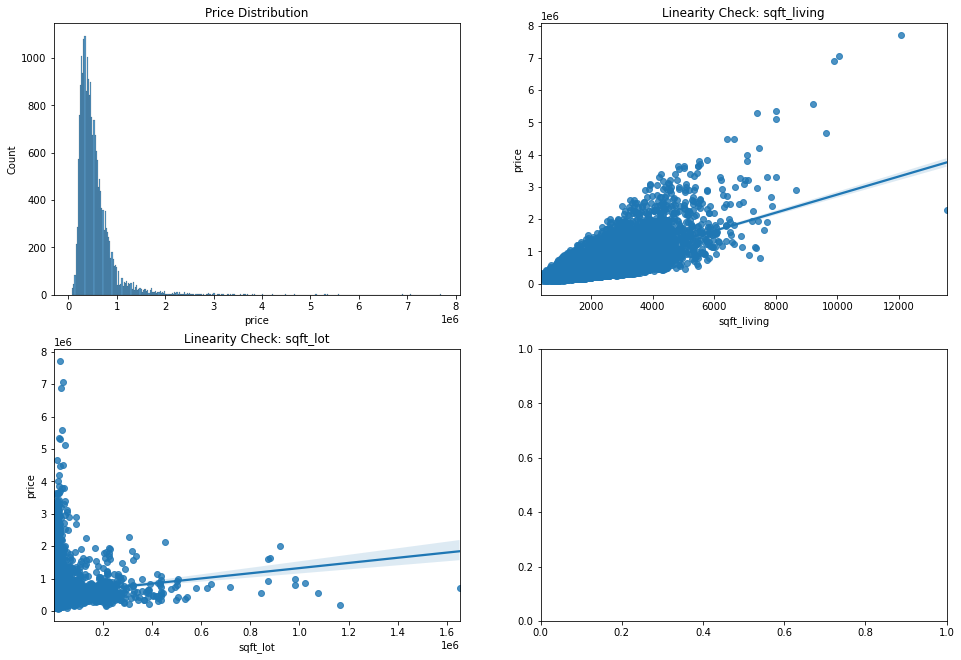

In [46]:
categorical = ['bedrooms','bathroo2ms','floors','waterfront','condition','grade']
cont = ['sqft_living','sqft_lot']

fig, axes = plt.subplots(2,2, figsize=(16, 11))

sns.histplot(df['price'], ax=axes[0][0]).set_title('Price Distribution')

# Regplot
for feat, ax in zip(cont, axes.flatten()[1:]): 
  sns.regplot(feat,'price', data=df, ax=ax).set_title(f'Linearity Check: {feat}')

fig.show()

**Interpretation**

Price has outliers on the high end - possibly remove outliers in an iteration.

sqft_lot has a weak positive correlation with price.

Try log transformation during modeling to reduce effect of outliers.

**Pre-Modeling Multicollinearity Check**

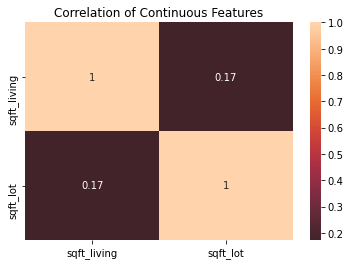

In [47]:
corr = df[cont].corr()
sns.heatmap(corr, center=0, annot=True).set_title('Correlation of Continuous Features');

Multicollinearity doesnt exist between sqft_living and sqft_lot.

**Train Test Split and Model Function**

In [49]:
#Name variables
X = df.drop('price', axis=1)
y = df['price']
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade
0,3,1.00,1180,5650,1.0,0,2,7
1,3,2.25,2570,7242,2.0,0,2,7
2,2,1.00,770,10000,1.0,0,2,6
3,4,3.00,1960,5000,1.0,0,4,7
4,3,2.00,1680,8080,1.0,0,2,8


In [50]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [51]:
#Model function
def model(X_train, X_test, y_train, y_test):
    
    # statsmodels
    
    features = X_train.copy()
    features['price'] = y_train
    
    formula = 'price~' + '+'.join(X_train.columns)
    model = ols(formula=formula, data=features).fit()
    
    # sklearn
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)

    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)

    print("Train R2: ", linreg.score(X_train, y_train))
    print("Test R2: ", linreg.score(X_test, y_test))

    print("Train RMSE: ", train_mse**0.5)
    print("Test RMSE: ", test_mse**0.5)
    
    # modified to display summary and return the model
    display(model.summary())
    return model

**Baseline Model**

Following, I will create a model with all features that will serve as our baseline.

In [52]:
model1 = model(X_train,X_test,y_train,y_test);

Train R2:  0.5930690032174879
Test R2:  0.5846682459099573
Train RMSE:  237521.44455420846
Test RMSE:  223472.84687545706


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     3146.
Date:                Sun, 10 Sep 2023   Prob (F-statistic):               0.00
Time:                        05:05:17   Log-Likelihood:            -2.3836e+05
No. Observations:               17276   AIC:                         4.767e+05
Df Residuals:                   17267   BIC:                         4.768e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6.505e+05   1.84e+04    -35.284      0.000   -6.87e+05   -6.14e+05
bedrooms    -4.209e+04   2586.958    -16.272      0.000   -4.72e+04    -3.7e+04
bathrooms   -1.081e+04   3983.539     -2.714      0.007   -1.86e+04   -3004.189
sqft_living   216.4590      3.961     54.648      0.000     208.695     224.223
sqft_lot       -0.4135      0.045     -9.252      0.000      -0.501      -0.326
floors      -2.208e+04   4088.337     -5.400      0.000   -3.01e+04   -1.41e+04
waterfront   8.419e+05   2.25e+04     37.499      0.000    7.98e+05    8.86e+05
condition    5.971e+04   2901.930     20.577      0.000     5.4e+04    6.54e+04
grade        1.039e+05   2561.007     40.566      0.000    9.89e+04    1.09e+05
==============================================================================
Omnibus:                    12569.877   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           723771.545
Skew:                           2.928   Prob(JB):                         0.00
Kurtosis:                      34.164   Cond. No.                     5.48e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.48e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpretation**
-The dependent variable being predicted is "price," which is the house price.

-The model's R-squared value (0.593) indicates how much of the variance in the target variable (house prices) is explained by the features. An R-squared of 0.593 is relatively good but suggests that there may still be room for improvement.

-The model's adjusted R-squared is the same as the R-squared in this case, meaning there are no penalties for the inclusion of additional features.

-The F-statistic (3146) and its associated p-value (0.00) suggest that the model, as a whole, is statistically significant.

-The coefficients (coef) for each feature represent how much the predicted price changes with a one-unit change in that feature, assuming all other features are constant. For example, a one-unit increase in square footage of living space (sqft_living) corresponds to an increase in predicted price of 216.4590 units, holding all other variables constant.

-The p-values associated with each coefficient indicate their statistical significance. In this case, most coefficients have p-values less than 0.05 (usually considered significant), except for "bathrooms" (p-value = 0.007), which suggests that the number of bathrooms might have a weaker effect on house prices in this model.


**Assumptions Check**

In [57]:
# Function for qq_plots
def qq_plot(model):
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

    ax0.hist(model.resid)
    ax0.set(xlabel='Residual', ylabel='Frequency', title='Distribution of Residuals')

    sm.qqplot(model.resid, stats.t, fit=True, line="45", ax=ax1)
    ax1.set(title='QQ Plot')

    fig.suptitle('Normality of Residuals')

    fig.show()
    return qq_plot

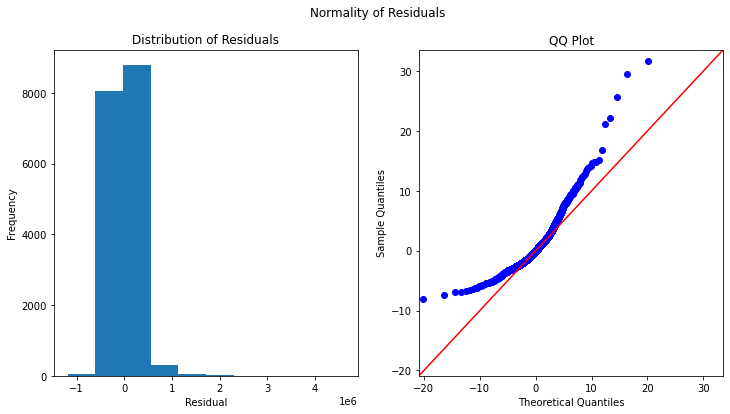

In [59]:
qq_plot(model1);

Our residuals are not normal, which violates the assumption of normality. I will try to remove outliers in our next iteration.

In [60]:
# Residual plot function
def residual_plot(X_train,X_test,y_train,y_test):

    linreg = LinearRegression()
    linreg.fit(X_train, y_train)

    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle('Residual Plots')

    axes[0].scatter(y_train, y_train-y_hat_train)
    axes[0].scatter(y_test, y_test-y_hat_test, color='orange')
    axes[0].set(xlabel='Actual Price', ylabel='residual', title='Residual per Price')
    axes[0].hlines(0, xmin=5, xmax=8000000, colors='red')

    axes[1].scatter(y_train, y_hat_train)
    axes[1].scatter(y_test, y_hat_test, color='orange')
    axes[1].plot([10, 8000000], [10, 5300000], color='red', linestyle='-')
    axes[1].set(xlabel='Actual Price', ylabel='Predicted Price', title='Actual vs Predicted Price')
    fig.show()
    
    return residual_plot

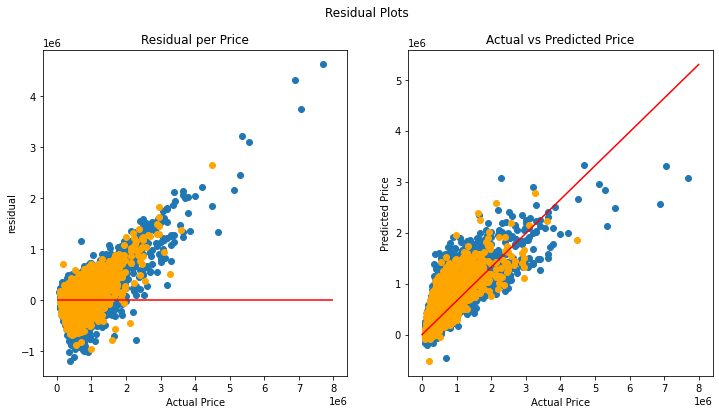

In [61]:
residual_plot(X_train,X_test,y_train,y_test);

Our results are not homoscedastic. We have inconsistent model performance mostly underpredicting as the sale price gets higher.

**Model 1 - Remove Outliers from Price**

The interquantile range (IQR) is the difference between the 75th (q75) and 25th percentiles (q25) of the data, therefore the middle 50% of the data. 1.5 multiplied by the IQR is a common way to identify and remove outliers that are less than q25 - (1.5 * IQR) and greater than q75 + (1.5 * IQR). I chose to remove outliers this way instead of 3 * std because the data was not normally distributed in the variables I was removing outliers from.

In [54]:
# Function to remove outliers
def remove_outliers(df):
    q25 = np.quantile(df,.25)
    q75 = np.quantile(df,.75)
    IQR = q75 - q25
    outliers = df.loc[((q25-1.5*IQR)>df) | (df>(q75+1.5*IQR))].index
    return outliers

In [55]:
def model_outlier(X_train, X_test, y_train, y_test):
   
    # remove outliers 
    train_outliers = remove_outliers(y_train)
    X_train = X_train.drop(train_outliers)
    y_train = y_train.drop(train_outliers)
    
    test_outliers = remove_outliers(y_test)
    X_test = X_test.drop(test_outliers)
    y_test = y_test.drop(test_outliers) 
    
   # statsmodels
    
    features = X_train.copy()
    features['price'] = y_train
    
    formula = 'price~' + '+'.join(X_train.columns)
    model = ols(formula=formula, data=features).fit()
    
    # sklearn
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)

    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)

    print("Train R2: ", linreg.score(X_train, y_train))
    print("Test R2: ", linreg.score(X_test, y_test))

    print("Train RMSE: ", train_mse**0.5)
    print("Test RMSE: ", test_mse**0.5)
    
    # display summary and return the model
    display(model.summary())
    return model

In [56]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X,y,test_size=0.2, random_state=123)
model2 = model_outlier(X_train2,X_test2,y_train2,y_test2);

Train R2:  0.4837947384212937
Test R2:  0.4779158409471108
Train RMSE:  148962.1025229978
Test RMSE:  150837.70351200973


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     1913.
Date:                Sun, 10 Sep 2023   Prob (F-statistic):               0.00
Time:                        05:39:27   Log-Likelihood:            -2.1781e+05
No. Observations:               16339   AIC:                         4.356e+05
Df Residuals:                   16330   BIC:                         4.357e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.927e+05   1.23e+04    -32.025      0.000   -4.17e+05   -3.69e+05
bedrooms     -1.42e+04   1713.074     -8.287      0.000   -1.76e+04   -1.08e+04
bathrooms   -1.329e+04   2618.075     -5.078      0.000   -1.84e+04   -8163.055
sqft_living   109.5330      2.802     39.096      0.000     104.041     115.024
sqft_lot       -0.0421      0.029     -1.444      0.149      -0.099       0.015
floors       6786.3716   2665.008      2.546      0.011    1562.665     1.2e+04
waterfront   1.976e+05   2.33e+04      8.469      0.000    1.52e+05    2.43e+05
condition     4.34e+04   1891.018     22.953      0.000    3.97e+04    4.71e+04
grade        8.138e+04   1713.433     47.498      0.000     7.8e+04    8.47e+04
==============================================================================
Omnibus:                      873.765   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1050.617
Skew:                           0.562   Prob(JB):                    7.27e-229
Kurtosis:                       3.527   Cond. No.                     8.71e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpretation**

Overall, while the R-squared value has decreased slightly, the model's predictive accuracy has improved as indicated by lower RMSE values. This means that our model may provide more accurate price predictions, which can be valuable for our business stakeholders when making real estate decisions. However, it's essential to keep refining and iterating on the model to further enhance its performance.

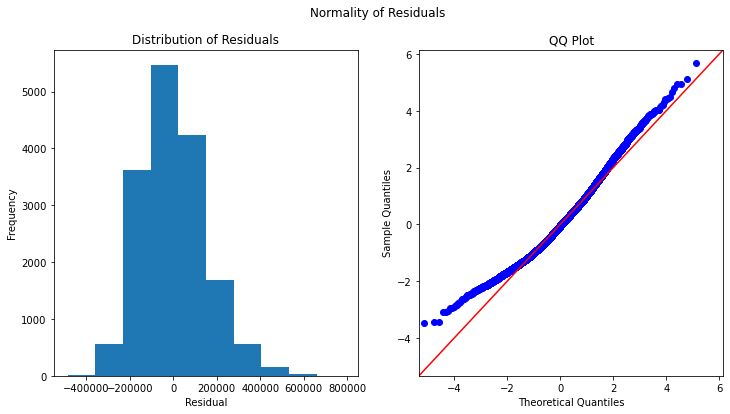

In [62]:

qq_plot(model2);

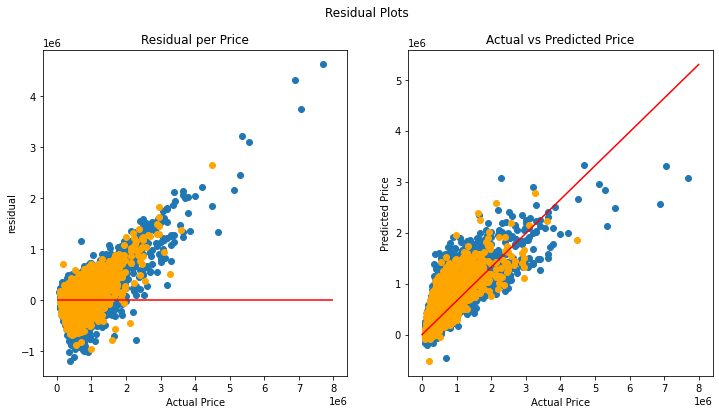

In [63]:
residual_plot(X_train2,X_test2,y_train2,y_test2);

**Model 2- Remove Outliers from Predictors**

In [64]:
sqft_lot_outliers = remove_outliers(df['sqft_lot'])

In [65]:
df = df.drop(sqft_lot_outliers)

In [66]:
sqft_living_outliers = remove_outliers(df['sqft_living'])

In [67]:
df = df.drop(sqft_living_outliers)

In [68]:
#Name variables
X_out = df.drop('price', axis=1)
y_out = df['price']
X.head()


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade
0,3,1.00,1180,5650,1.0,0,2,7
1,3,2.25,2570,7242,2.0,0,2,7
2,2,1.00,770,10000,1.0,0,2,6
3,4,3.00,1960,5000,1.0,0,4,7
4,3,2.00,1680,8080,1.0,0,2,8


In [69]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_out,y_out,test_size=0.2, random_state=123)
model3 = model_outlier(X_train3,X_test3,y_train3,y_test3);

Train R2:  0.4576974452253356
Test R2:  0.4665047397816361
Train RMSE:  143549.8969452645
Test RMSE:  141486.1204893414


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     1522.
Date:                Sun, 10 Sep 2023   Prob (F-statistic):               0.00
Time:                        05:57:32   Log-Likelihood:            -1.9185e+05
No. Observations:               14432   AIC:                         3.837e+05
Df Residuals:                   14423   BIC:                         3.838e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.292e+05   1.32e+04    -25.002      0.000   -3.55e+05   -3.03e+05
bedrooms    -1.206e+04   1800.072     -6.700      0.000   -1.56e+04   -8532.738
bathrooms   -2.651e+04   2734.925     -9.694      0.000   -3.19e+04   -2.12e+04
sqft_living   132.6182      3.199     41.462      0.000     126.349     138.888
sqft_lot      -10.0012      0.392    -25.509      0.000     -10.770      -9.233
floors      -2.129e+04   2985.039     -7.132      0.000   -2.71e+04   -1.54e+04
waterfront   3.067e+05      3e+04     10.217      0.000    2.48e+05    3.66e+05
condition    4.491e+04   1941.967     23.124      0.000    4.11e+04    4.87e+04
grade        8.431e+04   1840.946     45.795      0.000    8.07e+04    8.79e+04
==============================================================================
Omnibus:                      597.292   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              692.018
Skew:                           0.488   Prob(JB):                    5.37e-151
Kurtosis:                       3.445   Cond. No.                     2.07e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpretation**

Overall, although the R-squared has decreased slightly, our model's predictive accuracy has improved, as evidenced by lower RMSE values. This suggests that our model may provide more accurate price predictions, which can be highly valuable for our business stakeholders in making informed real estate decisions. We should continue to monitor and refine our model to achieve the best possible results.

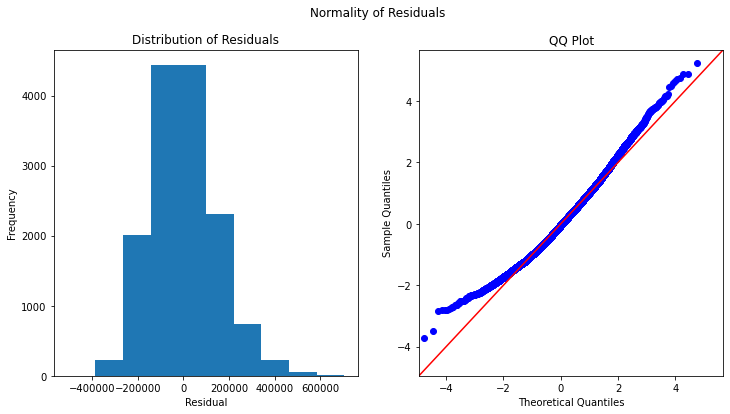

In [70]:
qq_plot(model3);

In [72]:
# Residual plot function
def residual_plot_scale(X_train,X_test,y_train,y_test):

    linreg = LinearRegression()
    linreg.fit(X_train, y_train)

    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle('Residual Plots')

    axes[0].scatter(y_train, y_train-y_hat_train)
    axes[0].scatter(y_test, y_test-y_hat_test, color='orange')
    axes[0].set(xlabel='Actual Price', ylabel='residual', title='Residual per Price')
    axes[0].hlines(0, xmin=5, xmax=3200000, colors='red')

    axes[1].scatter(y_train, y_hat_train)
    axes[1].scatter(y_test, y_hat_test, color='orange')
    axes[1].plot([10, 3200000], [10, 2500000], color='red', linestyle='-')
    axes[1].set(xlabel='Actual Price', ylabel='Predicted Price', title='Actual vs Predicted Price')
    fig.show()
    
    return residual_plot
    

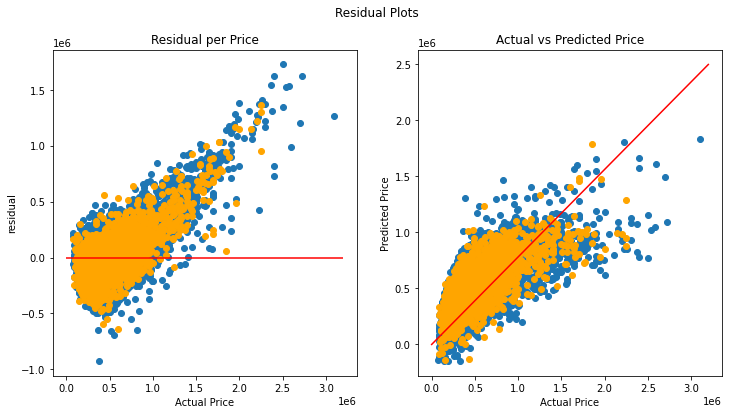

In [73]:

residual_plot_scale(X_train3,X_test3,y_train3,y_test3);

Distibution of residuals is close to normal, still have some light tails.
Fail homoscedasticity check, higher prices are underpredicted.

**Model 3 - Log Transformation**

For this iteration, I will log transform price.

In [81]:
high_p = ['sqft_lot']

In [82]:

#Create new dataframe with significant p-values
sig_X = X_out.drop(high_p, axis=1)

In [83]:
log_y = np.log(y_out)

In [84]:
# Model function to reverse log transform for metrics
def model_log(X_train, X_test, y_train, y_test):
    
    # statsmodels
    features = X_train.copy()
    features['price'] = y_train
    
    formula = 'price~' + '+'.join(X_train.columns)
    model = ols(formula=formula, data=features).fit()
    
    # sklearn
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_hat_train_log = linreg.predict(X_train)
    y_hat_test_log = linreg.predict(X_test)

    # reverse log transform
    y_train_rev = np.exp(y_train)
    y_test_rev = np.exp(y_test)
    y_hat_train = np.exp(y_hat_train_log)
    y_hat_test = np.exp(y_hat_test_log)
    
    
    train_mse = mean_squared_error(y_train_rev, y_hat_train)
    test_mse = mean_squared_error(y_test_rev, y_hat_test)

    print("Train R2: ", linreg.score(X_train, y_train))
    print("Test R2: ", linreg.score(X_test, y_test))

    print("Train RMSE: ", train_mse**0.5)
    print("Test RMSE: ", test_mse**0.5)
    
    # modified to display summary and return the model
    display(model.summary())
    return model

In [85]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(sig_X,log_y,test_size=0.2,random_state=123)
model5 = model_log(X_train5,X_test5,y_train5,y_test5);

Train R2:  0.49061130459710767
Test R2:  0.5181475060740656
Train RMSE:  186658.39378888032
Test RMSE:  182969.02976133215


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     2061.
Date:                Sun, 10 Sep 2023   Prob (F-statistic):               0.00
Time:                        06:21:56   Log-Likelihood:                -5221.2
No. Observations:               14989   AIC:                         1.046e+04
Df Residuals:                   14981   BIC:                         1.052e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      10.8973      0.030    366.507      0.000      10.839      10.956
bedrooms       -0.0365      0.004     -8.764      0.000      -0.045      -0.028
bathrooms      -0.0209      0.006     -3.306      0.001      -0.033      -0.009
sqft_living     0.0003   7.19e-06     36.115      0.000       0.000       0.000
floors          0.0197      0.006      3.062      0.002       0.007       0.032
waterfront      0.6671      0.048     13.982      0.000       0.574       0.761
condition       0.1063      0.004     23.625      0.000       0.097       0.115
grade           0.1956      0.004     46.340      0.000       0.187       0.204
==============================================================================
Omnibus:                       31.220   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.222
Skew:                           0.035   Prob(JB):                     2.02e-06
Kurtosis:                       2.808   Cond. No.                     3.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [88]:
# Update qq_plot function to save fig
def qq_plot(model):
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

    ax0.hist(model.resid)
    ax0.set(xlabel='Residual', ylabel='Frequency', title='Distribution of Residuals')

    sm.qqplot(model.resid, stats.t, fit=True, line="45", ax=ax1)
    ax1.set(title='QQ Plot')

    fig.suptitle('Normality of Residuals')

    fig.show()
    return qq_plot

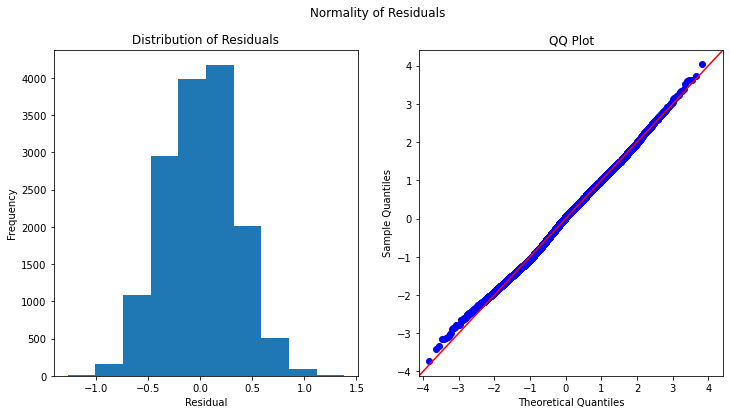

In [89]:

qq_plot(model5);

In [92]:
# Residual plot function
def residual_plot_log(X_train,X_test,y_train,y_test):

    linreg = LinearRegression()
    linreg.fit(X_train, y_train)

    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle('Residual Plots')

    axes[0].scatter(y_train, y_train-y_hat_train)
    axes[0].scatter(y_test, y_test-y_hat_test, color='orange')
    axes[0].set(xlabel='Actual Price', ylabel='residual', title='Residual per Price')
    axes[0].hlines(0, xmin=11, xmax=15, colors='red')

    axes[1].scatter(y_train, y_hat_train)
    axes[1].scatter(y_test, y_hat_test, color='orange')
    axes[1].plot([11.5, 15], [11.5, 15], color='red', linestyle='-')
    axes[1].set(xlabel='Actual Price', ylabel='Predicted Price', title='Actual vs Predicted Price')
    fig.show()
    return residual_plot_log
    

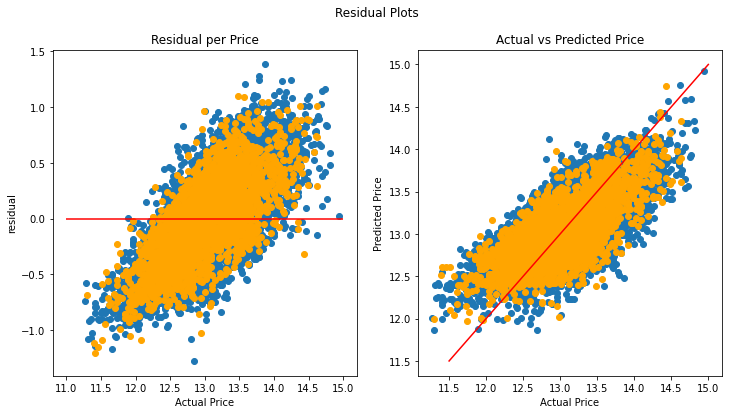

In [93]:
residual_plot_log(X_train5,X_test5,y_train5,y_test5);

**Interpretation**
R2 was 0.458, we have improved in this model to 0.491.
Train RMSE: 186,658.29; Test RMSE: 182,969.03. Higher RMSE from ~143,000.
Difference between train and test RMSE is acceptable. Model is not overfittted.
Distibution of residuals is close to normal, still have some light tails indicating that errors are likely for extreme values.
Homoscedasticity has greatly improved! Homes on the lower end now are more overpredicted, but due to the fact that we want a wide range of prices in our model it is acceptable.
Even though our RMSE has increased, this is our best performing model because it passes the assumptions of regression.

# Scale the Final Model

To determine which features have the most impact on sale price, I will update my model fuction to scale the data using Standard Scaler. This will allow us to compare the effects of each feature on a level playing field.

In [95]:
# Model function to reverse log transform for metrics
def model_scale_log(X_train, X_test, y_train, y_test):
    
    standardizer = StandardScaler()

    X_train_scaled = pd.DataFrame(standardizer.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(standardizer.transform(X_test), columns=X_test.columns)
    
    X_train_scaled['price'] = y_train.values
    X_test_scaled['price'] = y_test.values
    
    # statsmodels
    outcome = 'price'
    predictors = X_train_scaled.drop('price', axis=1)
    pred_sum = '+'.join(predictors.columns)
    formula = outcome + '~' + pred_sum
    model = ols(formula=formula, data=X_train_scaled).fit()
    
    # sklearn
    X_train_scaled = X_train_scaled.drop('price', axis=1)
    X_test_scaled = X_test_scaled.drop('price', axis=1)
    
    linreg = LinearRegression()
    linreg.fit(X_train_scaled, y_train)
    
    y_hat_train_log = linreg.predict(X_train_scaled)
    y_hat_test_log = linreg.predict(X_test_scaled)
    
    # reverse log transform
    y_train_rev = np.exp(y_train)
    y_test_rev = np.exp(y_test)
    y_hat_train = np.exp(y_hat_train_log)
    y_hat_test = np.exp(y_hat_test_log)
    
    train_mse = mean_squared_error(y_train_rev, y_hat_train)
    test_mse = mean_squared_error(y_test_rev, y_hat_test)

    print("Train R2: ", linreg.score(X_train_scaled, y_train))
    print("Test R2: ", linreg.score(X_test_scaled, y_test))

    print("Train RMSE: ", train_mse**0.5)
    print("Test RMSE: ", test_mse**0.5)
    
    # modified to display summary and return the model
    display(model.summary())
    return model


In [96]:
X_train6, X_test6, y_train6, y_test6 = train_test_split(sig_X,log_y,test_size=0.2,random_state=123)
model6 = model_scale_log(X_train6,X_test6,y_train6,y_test6);

Train R2:  0.49061130459710767
Test R2:  0.5181475060740557
Train RMSE:  186658.3937888863
Test RMSE:  182969.0297613408


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     2061.
Date:                Sun, 10 Sep 2023   Prob (F-statistic):               0.00
Time:                        06:45:28   Log-Likelihood:                -5221.2
No. Observations:               14989   AIC:                         1.046e+04
Df Residuals:                   14981   BIC:                         1.052e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.9911      0.003   4638.466      0.000      12.986      12.997
bedrooms       -0.0322      0.004     -8.764      0.000      -0.039      -0.025
bathrooms      -0.0147      0.004     -3.306      0.001      -0.023      -0.006
sqft_living     0.1872      0.005     36.115      0.000       0.177       0.197
floors          0.0106      0.003      3.062      0.002       0.004       0.017
waterfront      0.0392      0.003     13.982      0.000       0.034       0.045
condition       0.0692      0.003     23.625      0.000       0.063       0.075
grade           0.1975      0.004     46.340      0.000       0.189       0.206
==============================================================================
Omnibus:                       31.220   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.222
Skew:                           0.035   Prob(JB):                     2.02e-06
Kurtosis:                       2.808   Cond. No.                         3.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
model6.params.sort_values(ascending=False).head(50)

Intercept      12.991108
grade           0.197454
sqft_living     0.187173
condition       0.069224
waterfront      0.039226
floors          0.010650
bathrooms      -0.014737
bedrooms       -0.032194
dtype: float64

Features with the most impact on sale price ranked. The features with the most positive impact on sale price in relation to renovation are grade and sqft_living 

**Results:**

In our final scaled model, we have achieved an R-squared value of 0.491, which indicates that approximately 49.1% of the variation in house prices can be explained by the selected features. This represents a slight improvement in model performance compared to previous iterations. 

Among the key features, "grade" and "sqft_living" have the most positive impact on sale price, suggesting that investing in improving the quality of the house and increasing its living space could potentially lead to higher resale values. However, it's crucial to note that the impact of some features, such as "bathrooms" and "bedrooms," appears to be negative, which means that simply adding more of these features may not necessarily increase the resale value.



**Limitations**

Limitations of this model include the fact that it still relies on simplified linear relationships between features and house prices. It doesn't capture all the nuances and interactions that could exist in the real estate market. Additionally, while the R-squared value has improved, there's room for further refinement. 

**Recommendations**

Stakeholders looking to remodel houses and maximize resale value should consider that this model provides valuable insights into feature importance but may not account for external factors or market dynamics that can influence pricing. To achieve the best results, they should continue to gather local market information, consult with real estate experts, and consider other factors like location and market demand when making renovation decisions. Ultimately, a holistic approach that combines data-driven insights with market expertise will lead to the most profitable post-renovation strategy.